In [13]:
import os
import re  # 引入正则表达式库，用于提取数字
import torch
import random
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from Model.ResNet50_model import resnet50
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter as swriter
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
cpu_cores = os.cpu_count() 
print(f"Number of CPU cores available: {cpu_cores}")

cuda_available = torch.cuda.is_available()
print(f"Is CUDA available: {cuda_available}")

memory = psutil.virtual_memory()
total_memory_gb = memory.total / (1024 ** 3)  # 转换为GB
available_memory_gb = memory.available / (1024 ** 3)  # 转换为GB

print(f"Total RAM: {total_memory_gb:.2f} GB")
print(f"Available RAM: {available_memory_gb:.2f} GB")

if torch.cuda.is_available():
    print(f"Total GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)} - Total memory: {torch.cuda.get_device_properties(i).total_memory / 1e6} MB")
else:
    print("No CUDA GPUs are available")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device:', device)
print(torch.cuda.get_device_capability(device))
properties = torch.cuda.get_device_properties(device)

sm_count = properties.multi_processor_count
cores_per_sm = 128  # 每个 SM 有多少个 CUDA 核心
total_cores = sm_count * cores_per_sm

print(f"Total CUDA cores: {total_cores}")

Number of CPU cores available: 24
Is CUDA available: True
Total RAM: 15.49 GB
Available RAM: 13.33 GB
Total GPUs: 1
Device 0: NVIDIA GeForce RTX 4070 Laptop GPU - Total memory: 8585.216 MB
device: cuda
(8, 9)
Total CUDA cores: 4608


In [4]:
class RandomCropAndResize(transforms.Resize):
    def __init__(self, original_size=120, scale_min=0.92, scale_max=1.00, interpolation=Image.BILINEAR):
        # 2D图片使用BICUBIC(三维双线性插值：针对3D图片)会出现1：插值后的图只显示轮廓(见0714不深入) 
        super().__init__(size=(original_size, original_size), interpolation=interpolation)
        self.original_size = original_size
        self.scale_min = scale_min
        self.scale_max = scale_max

    def __call__(self, img):
        # 计算裁剪尺寸
        scale = random.uniform(self.scale_min, self.scale_max)
        crop_size = int(self.original_size * scale)

        # 中心裁剪
        center_crop = transforms.CenterCrop(crop_size)
        img = center_crop(img)

        # 调整尺寸回原始尺寸
        img = super().__call__(img)

        return img

# 下面自定义的数据集中__len__和__getitem__是必须被实现的方法，因为它们定义了数据集基本行为：大小和如何被索引
class BacteriaDataset(Dataset): # 通过继承torch的dataset,使得自定义的数据集可配合torch的其它数据工具一起使用，如dataloader，使得自定义数据集兼容标准数据加载到模型的流程
    def __init__(self, folder_path, label, transform=None, target_transform=None): # transfrom对图像的转换。 target_transform是对标签的转换：例如独热编码和标签映射等
        self.folder_path = folder_path
        self.label = label
        self.transform = transform
        self.target_transform = target_transform
        self.images = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.tif')]

    def __len__(self): # 该方法返回数据集元素总数，pytorch的dataloader依此决定数据集的遍历次数
        return len(self.images)

    def __getitem__(self, idx): # 该方法根据索引idx返回数据集中的单个元素，如使用dataloader迭代数据集时.__getitem__方法的调用还可如右所示，直接datasets[3][i]
        image_path = self.images[idx]
        image = np.array(Image.open(image_path))  # .convert('L'):Convert to grayscale
        image = (image/np.max(image) * 255).astype(np.uint8) # 把我的16位变成0~1再转换为8位np, 再给下面处理，不然直接给下面16位的它会给我丢失细节

        # image = Image.fromarray(array, mode = 'I;16')
        image = Image.fromarray(image, mode='L') # mode='L' 会转换为8位的PIL,所以上一些我先转成8位np以免细节丢失
        if self.transform:
            image = self.transform(image)
        return image, self.label

# 定义变换
transform = transforms.Compose([
    # transforms.RandomRotation(180),  # 360度旋转
    # RandomCropAndResize(),  # 缩放操作
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform1 = transforms.Compose([
    transforms.RandomRotation(180),  # 360度旋转
    RandomCropAndResize(original_size=150),  # 缩放操作
    transforms.RandomHorizontalFlip(),
    # transforms.ToTensor()
])

In [6]:
os.getcwd()
train_data_path = os.path.join(os.getcwd(),'Cellwalltest_20241219')
train_data_path

'/mnt/e/wsl_share/Machine_learning/DR/DR_latest/HJ/Cellwalltest_20241219'

In [8]:
folders = ['stage1', 'stage2', 'stage3', 'stage4', 'stage5']
labels = [1, 2, 3, 4, 5]
# folders = ['error']
# labels = [6]
datasets = [BacteriaDataset(f"/mnt/e/wsl_share/Machine_learning/DR/DR_latest/HJ/Cellwalltest_20241219/{folder}", label, transform=transform) for folder, label in zip(folders, labels)]
print(datasets)

# 扩增数据并保存
def amplify_and_save(dataset, folder_name, amplification=20):
    # save_path = f"./dr_cell_cycle/{folder_name}_amplification" #0605
    save_path = f"/mnt/e/wsl_share/Machine_learning/DR/DR_latest/HJ/Cellwalltest_20241219/{folder_name}_amplification" #
    os.makedirs(save_path, exist_ok=True)

    loader = DataLoader(dataset, batch_size=1, shuffle=True) # DataLoader已经调用了数据集的__getitem__方法，该方法包括转换，因此不需要再次转换成张量
    for i, (image, label) in enumerate(loader, 1): # 这里image是torch.tensor (1,1,120,120)且范围是0~1 ,这是关键点，Uint16位被读取成data
        for j in range(amplification): # (image,_) in enumerate
            # image1 = np.array(image).reshape(140,140) #H*W
            # image2 = (image1/np.max(image1) * 255).astype(np.uint8) # 因为transforms内的函数ToTensor接受8位的PIL或ndarray，所以这里先变成ndarray8位
            
            # image3 = Image.fromarray(image2, mode = 'L') #H*W # image = Image.fromarray(array, mode = 'I;16')改成这样会出错，因为transforms接受8位，头痛
            
            # image3 = Image.fromarray(image2, mode = 'L')

            # 这里image本身是tensor情况下，transform1内的ToTensor要被注释掉
            image4 = (transform1(image)).numpy().squeeze() # ToTensor会增加一个C维度，先C=1*H*W，再变成H*W
            # transformed_image = dataset.transform(image.squeeze(0))  # 若图片不是张量，这里进行转换。
            imageidx = (i-1)*amplification + j + 1
            save_image(image4, f"{save_path}/{folder_name}_amp_{imageidx}.tif") # {}.tif被我去掉了

def save_image(array, filename):
    if array.dtype != np.uint16:
        array = (array*65535).astype(np.uint16)
    
    image = Image.fromarray(array, mode = 'I;16')
    image.save(filename,format = 'TIFF')

Amplifications = [7, 6, 8, 50, 250]  
# 为每个数据集执行扩增和保存，使用enumerate来获取循环迭代序号i
for i, (dataset, folder) in enumerate(zip(datasets, folders), start=1):
    amplification_value = Amplifications[i-1]
    amplify_and_save(dataset, folder, amplification=amplification_value)

[<__main__.BacteriaDataset object at 0x7fc6c0292440>, <__main__.BacteriaDataset object at 0x7fc6cd5db790>, <__main__.BacteriaDataset object at 0x7fc6c1a2e4d0>, <__main__.BacteriaDataset object at 0x7fc6c1a2e530>, <__main__.BacteriaDataset object at 0x7fc7ac5c0970>]


In [42]:
# 下面自定义的数据集中__len__和__getitem__是必须被实现的方法，因为它们定义了数据集基本行为：大小和如何被索引
class BacteriaDataset(Dataset): # 通过继承torch的dataset,使得自定义的数据集可配合torch的其它数据工具一起使用，如dataloader，使得自定义数据集兼容标准数据加载到模型的流程
    def __init__(self, folder_path, label, transform=None, target_transform=None): # transfrom对图像的转换。 target_transform是对标签的转换：例如独热编码和标签映射等
        self.folder_path = folder_path
        self.label = label
        self.transform = transform
        self.target_transform = target_transform
        self.images = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.tif')]

    def __len__(self): # 该方法返回数据集元素总数，pytorch的dataloader依此决定数据集的遍历次数
        return len(self.images)

    def __getitem__(self, idx): # 该方法根据索引idx返回数据集中的单个元素，如使用dataloader迭代数据集时.__getitem__方法的调用还可如右所示，直接datasets[3][i]
        image_path = self.images[idx]
        image = np.array(Image.open(image_path))  # .convert('L'):Convert to grayscale
        image = (image/np.max(image) * 255).astype(np.uint8)
        image = Image.fromarray(image, mode='L') # mode='L' 会转换为8位的PIL,所以上一些我先转成8位np以免细节丢失
        if self.transform:
            image = self.transform(image)
        return image, self.label

# 训练集的数据预处理变换
transform = transforms.Compose([
    
    transforms.ToTensor(),  # 最后转换为tensor
])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 的概率水平翻转
    # transforms.RandomHorizontalFlip(), # 不填参数默认p=0.5
    transforms.RandomVerticalFlip(p=0.5),    # 50% 的概率垂直翻转
    transforms.RandomRotation(degrees=(0, 180)),  # 随机旋转0到180度
    # transforms.RandomRotation(180),  # 360度旋转,这时单一参数被理解为-180 到 + 180
    
    transforms.RandomResizedCrop(224, scale=(0.90, 1.0),  ratio = (1, 1)),
    
    # 使用Lambda创建自定义操作，来调用任何函数并指定用于该操作的参数。
    transforms.Lambda(lambda x: transforms.functional.adjust_brightness(x, brightness_factor=random.uniform(0.8, 1.2))),
    transforms.Lambda(lambda x: transforms.functional.adjust_contrast(x, contrast_factor=random.uniform(0.8, 1.2))),
    
    # transforms.RandomCrop(size=(100, 100), padding=None),  # 随机裁剪到100x100大小
    # RandomCropAndResize(),  # 缩放操作
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),  # 随机仿射变换 轻微地旋转 (±10度)，在宽度和高度上平移最多 10%，缩放比例在 80% 到 120% 之间变化，并且可能轻微地沿 x 或 y 轴倾斜±10°
    
    # transforms.Grayscale(num_output_channels=3),  # 将单通道转换为三通道
    # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    transforms.Normalize(mean=0.5, std=0.5),
    # transforms.ToTensor()
])
# ColorJitter只对RGB生效，对灰度图不生效。
# transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 颜色抖动.brightness=0.2表示0.8到1.2随机调整亮度。对比，饱和和色调同理是± 参数 


# 验证集的数据预处理
transform_val = transforms.Compose([
    # 将输入图像大小调整为224*224，PIL的size返回的是w，h。注意transforms.Resize只接受PIL和torchtensor，不接受cv2和io读取的ndarray数据
    transforms.Resize((224,224)),
    transforms.RandomRotation(degrees=(0, 180)),
    # transforms.Grayscale(num_output_channels=3),  # 将单通道转换为三通道
    transforms.Normalize(mean=0.5, std=0.5),
    # transforms.ToTensor()
    # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

In [15]:
folders = ['stage1_amplification', 'stage2_amplification', 'stage3_amplification', 'stage4_amplification', 'stage5_amplification']
labels = [0, 1, 2, 3, 4]
oxhdatasets = [BacteriaDataset(f"/mnt/e/wsl_share/Machine_learning/DR/DR_latest/HJ/Cellwalltest_20241219/{folder}", label, transform=transform) for folder, label in zip(folders, labels)]

In [16]:
from torch.utils.data import random_split, ConcatDataset
# data_loader = DataLoader(dataset, batch_size=50, shuffle=False, num_workers=8)
# 定义一个函数来分割数据集并合并
def create_train_test_datasets(datasets, test_split=0.2):
    train_datasets = []
    test_datasets = []

    for dataset in datasets:
        num_total = len(dataset)
        num_test = int(num_total * test_split)
        num_train = num_total - num_test

        train_subset, test_subset = random_split(dataset, [num_train, num_test])
        train_datasets.append(train_subset)
        test_datasets.append(test_subset)

    # 合并所有训练集和测试集
    train_data = ConcatDataset(train_datasets)
    test_data = ConcatDataset(test_datasets)

    return train_data, test_data

train_data, test_data = create_train_test_datasets(oxhdatasets)

In [17]:
# DataLoader迭代时动态应用变换
def train_collate_fn(batch):
    transformed_batch = [(transform_train(img), label) for img, label in batch]
    return torch.utils.data.dataloader.default_collate(transformed_batch)

def test_collate_fn(batch):
    transformed_batch = [(transform_val(img), label) for img, label in batch]
    return torch.utils.data.dataloader.default_collate(transformed_batch)

# 创建DataLoader时指定collate_fn
train_loader = DataLoader(dataset=train_data, batch_size=48, shuffle=True, collate_fn=train_collate_fn, num_workers = 8)
test_loader = DataLoader(dataset=test_data, batch_size=48, shuffle=False, collate_fn=test_collate_fn, num_workers = 8)
class_names = ['stage1', 'stage2', 'stage3', 'stage4', 'stage5']
print(class_names[labels[2]])

stage3


In [49]:
train_batch1 = next(iter(train_loader)) # train_img, train_label = next(iter(train_loader)) 分别读取图片和标签
test_batch1 = next(iter(DataLoader(dataset=test_data, batch_size=48, shuffle=False, collate_fn=test_collate_fn, num_workers = 8)))#每次加载还得数据进行数据增强
print('train_batch1', len(train_batch1))
print('test_batch1', len(test_batch1))
print(len(train_data))
print(len(test_data))

train_batch1 2
test_batch1 2
9058
2263


In [50]:
test_batch1[0].shape

torch.Size([48, 1, 224, 224])

[3 1 1 1 3 1 5 3 2]


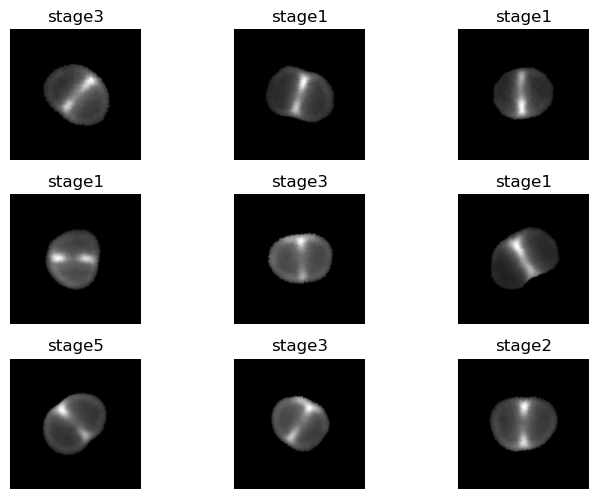

In [51]:
img = test_batch1[0][:9]
img = img/2 + 0.5
img = img.permute(0,2,3,1).numpy()
class_label = train_batch1[1][:9].numpy()
print(class_label+1)
plt.figure() # plt.figure(dpi = 100)
for i in range(img.shape[0]):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i], cmap='gray')
    plt.axis('off') # plt.xticks([])  plt.yticks([]) 不显示坐标轴刻度
    plt.title(class_names[class_label[i]])
plt.tight_layout(pad=0, w_pad = 5 , h_pad = 1) # 紧凑轻量化布局
plt.show()

In [52]:
os.getcwd()

'/mnt/e/wsl_share/Machine_learning/DR/DR_latest/HJ'

In [60]:
weightpath = '/root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth'# 1000分类预训练网络参数
savepath = '/mnt/e/wsl_share/Machine_learning/DR/DR_latest/HJ/Model/'
oxhnet = resnet50(num_classes = 1000) # 接受预训练的网络1000分类的网络权重参数
oxhnet.load_state_dict(torch.load(weightpath, map_location=device))
print('oxhnet.fc.in_features:', oxhnet.fc.in_features)
print('oxhnet.conv1.in_features:', oxhnet.conv1.in_channels)
in_channel = oxhnet.fc.in_features
in_channel0 = oxhnet.conv1.in_channels
oxhnet.fc = nn.Linear(in_channel, 5) # 只有全连接层的参数全部初始化了，其余层仍旧保留迁移过来的权重
oxhnet.conv1 = nn.Conv2d(1, 64,kernel_size=7,stride=2,padding=3,bias=False)
print('after revied, oxhnet.fc: ', oxhnet.fc)
print('after revied, oxhnet.conv1: ', oxhnet.conv1)
oxhnet.to(device)

oxhnet.fc.in_features: 2048
oxhnet.conv1.in_features: 3
after revied, oxhnet.fc:  Linear(in_features=2048, out_features=5, bias=True)
after revied, oxhnet.conv1:  Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [56]:
# 初始化tensorboard
writer = swriter('runs/20241221_ResNet50_5features_ForDR(CellWall)')
dummy_input = torch.randn(1,1,224,224).to(device=device, dtype=torch.float32)
# 模型计算图添加到tensorboard
writer.add_graph(oxhnet, dummy_input)

In [61]:
epochs = 30 # 训练10轮次
best_acc = 0.0 # 保存正确率最高的一次迭代的权重参数
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(oxhnet.parameters(), lr = 0.002)
# -------------------------------------------------- #
#（5）网络训练
# -------------------------------------------------- #
for epoch in range(epochs):
    
    print('-'*30, '\n', 'epoch:', epoch)
    
    # 将模型设置为训练模型, dropout层和BN层只在训练时起作用
    oxhnet.train()
    
    # 计算训练一个epoch的总损失
    running_loss = 0.0
    r_loss = 0.0
    # 每个step训练一个batch
    #
    # 用其来代替train_loader实现每epoch重新数据强化：DataLoader(dataset=train_data, batch_size=48, shuffle=True, collate_fn=train_collate_fn, num_workers = 8)
    for step, data in enumerate(DataLoader(dataset=train_data, batch_size=48, shuffle=True, collate_fn=train_collate_fn, num_workers = 8)):
        # data中包含图像及其对应的标签
        images, labels = data
        
        # 梯度清零，因为每次计算梯度是一个累加
        optimizer.zero_grad()
        
        # 前向传播
        outputs = oxhnet(images.to(device))
        
        # 计算预测值和真实值的交叉熵损失
        loss = loss_function(outputs, labels.to(device))
        
        # 梯度计算
        loss.backward()
        
        # 权重更新
        optimizer.step()
        
        # 累加每个step的损失
        running_loss += loss.item()
        
        # 打印每个step的损失
        print(f'step:{step} loss:{loss}')

        # 每个epoch写100次平均损失函数数值大小
        r_loss += loss.item()
        if (step+1)%10 == 0: # 100*10 datapoints
            avg_loss = r_loss / 10
            writer.add_scalar('training loss_10batchesPerPoint', avg_loss, epoch * len(train_loader) + step)
            r_loss = 0.0
    
# -------------------------------------------------- #
#（6）网络验证
# -------------------------------------------------- #
    oxhnet.eval()  # 切换为验证模型，BN和Dropout不起作用
    
    acc = 0.0   # 验证集准确率
    ac = 0.0
    
    with torch.no_grad():  # 下面不进行梯度计算
        
        # 每次验证一个batch, 该batch内所有图片进行预测，然后和标准标签对比看正确率，再进行累加，恐怖啊，要预测10轮
        for i, data_test in enumerate(test_loader):
        # for data_test in val_loader:
            
            # 获取验证集的图片和标签
            test_images, test_labels = data_test
            
            # 前向传播
            outputs = oxhnet(test_images.to(device))
            
            # 预测分数的最大值
            predict_y = torch.max(outputs, dim=1)[1]
            
            # 累加每个step的准确率
            acc += (predict_y == test_labels.to(device)).sum().item()
            
            ac += (predict_y == test_labels.to(device)).sum().item()
            if (i+1)%10 == 0: # 20 *10 datapoints
                avg_acc = ac / (10*20)
                writer.add_scalar('prediction accuracy_10batcheserPoint', avg_acc, epoch * len(test_loader) + i)
                ac = 0.0
        
        # 计算所有图片的平均准确率
        acc_test = acc / len(test_data)
        
        # 打印每个epoch的训练损失和验证准确率
        print(f'total_train_loss:{running_loss/step}, total_test_acc:{acc_test}')
 
        
# -------------------------------------------------- #
#（7）权重保存
# -------------------------------------------------- #
        # 保存最好的准确率的权重
        if acc_test > best_acc:
            # 更新最佳的准确率
            best_acc = acc_test
            # 保存的权重名称
            savename = savepath + 'resnet50ForDR_5features(CellWall).pth'
            # 保存当前权重
            torch.save(oxhnet.state_dict(), savename)

------------------------------ 
 epoch: 0
step:0 loss:1.6035271883010864
step:1 loss:1.6302465200424194
step:2 loss:1.3690825700759888
step:3 loss:1.3540573120117188
step:4 loss:1.2592564821243286
step:5 loss:1.2845605611801147
step:6 loss:1.079199194908142
step:7 loss:1.0090237855911255
step:8 loss:1.0924924612045288
step:9 loss:0.8852604031562805
step:10 loss:1.1348447799682617
step:11 loss:0.6175020337104797
step:12 loss:0.7166128754615784
step:13 loss:0.7342467904090881
step:14 loss:0.9203248023986816
step:15 loss:1.0118359327316284
step:16 loss:0.7615394592285156
step:17 loss:0.7947375178337097
step:18 loss:0.6418563723564148
step:19 loss:0.6670253872871399
step:20 loss:0.9450673460960388
step:21 loss:0.6639299988746643
step:22 loss:0.7289277911186218
step:23 loss:0.6399421691894531
step:24 loss:0.9038012027740479
step:25 loss:0.8408329486846924
step:26 loss:0.7358719706535339
step:27 loss:0.754784882068634
step:28 loss:0.8503828048706055
step:29 loss:0.9582095146179199
step:30 lo

In [59]:
oxhnet.eval()  # Set the model to evaluation mode

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = oxhnet(images)
        _, predicted = torch.max(outputs, dim=1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算混淆矩阵和分类报告
conf_matrix = confusion_matrix(all_labels, all_predictions)
class_report = classification_report(all_labels, all_predictions, target_names=class_names, output_dict=True)

# 将混淆矩阵转换为 DataFrame 并明确标识预测和真实
conf_matrix_df = pd.DataFrame(
    conf_matrix, 
    index=[f'{cn}_true' for cn in class_names], 
    columns=[f'{cn}_pred' for cn in class_names]
)

# 将分类报告转换为 DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# 确保输出目录存在
output_dir = './runs/20241221_ResNet50_5features_ForDR(CellWall)'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 写入 CSV
output_csv = os.path.join(output_dir, '20241221confusion_matrix_and_classification_report.csv')
conf_matrix_df.to_csv(output_csv, mode='w')  # Write mode
class_report_df.to_csv(output_csv, mode='a')  # Append mode

In [ ]:
oxhnet.eval()  # Set model to evaluation mode

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = oxhnet(images.to(device))
        probabilities = torch.softmax(outputs, dim=1)
        top_p, top_class = probabilities.topk(2, dim=1)  # Get top 2 predictions
        _, predicted = torch.max(probabilities, 1)  # Get the index of max log-probability
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        if i == 0:  # Process only the first batch
            plt.figure(figsize=(15, 12))  # Define the size of the figure

            for j in range(images.shape[0]):
                plt.subplot(4, 5, j + 1)
                img = images[j].cpu().squeeze()  # Assuming images are already in CPU and grayscale
                plt.imshow(img, cmap='gray')
                title_text = f"True: {class_names[labels[j]]}\n" \
                             f"1st: {class_names[top_class[j][0]]} ({top_p[j][0]:.2f})\n" \
                             f"2nd: {class_names[top_class[j][1]]} ({top_p[j][1]:.2f})"
                plt.title(title_text, fontsize=10)
                plt.axis('off')

            plt.subplots_adjust(hspace=0.3, wspace=0.1)
            result_directory = './0729DR_SingleCell_padding_Classified'
            if not os.path.exists(result_directory):
                os.makedirs(result_directory)
            image_filename = os.path.join(result_directory, 'prediction_results.png')
            plt.savefig(image_filename)
            plt.show()
            break  # Stop after processing the first batch

# Calculate and print accuracy
accuracy = (correct / total) * 100
print(f'Accuracy of the network on the train images: {accuracy:.2f}%')
print('Test Accuracy: {:.2f}%'.format(100 * correct / total))
print('True labels:     ', labels)
print('Predicted labels:', predicted)